<a href="https://colab.research.google.com/github/amitpanwarIndia/DLOps/blob/main/M22AIE202_DLOps_Assignment_Q2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2024-03-17 16:58:04--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.77, 18.160.200.112, 18.160.200.71, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   158MB/s    in 0.3s    

2024-03-17 16:58:04 (158 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_dat

Epoch [1/20], Loss: 0.0804
Epoch [2/20], Loss: 0.0471
Epoch [3/20], Loss: 0.0353
Epoch [4/20], Loss: 0.0291
Epoch [5/20], Loss: 0.0252
Epoch [6/20], Loss: 0.0224
Epoch [7/20], Loss: 0.0206
Epoch [8/20], Loss: 0.0189
Epoch [9/20], Loss: 0.0172
Epoch [10/20], Loss: 0.0153
Epoch [11/20], Loss: 0.0145
Epoch [12/20], Loss: 0.0138
Epoch [13/20], Loss: 0.0129
Epoch [14/20], Loss: 0.0127
Epoch [15/20], Loss: 0.0121
Epoch [16/20], Loss: 0.0116
Epoch [17/20], Loss: 0.0114
Epoch [18/20], Loss: 0.0107
Epoch [19/20], Loss: 0.0105
Epoch [20/20], Loss: 0.0099


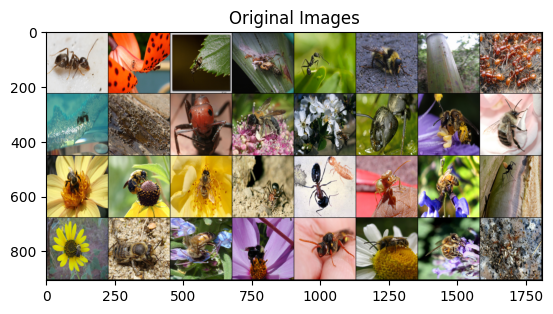

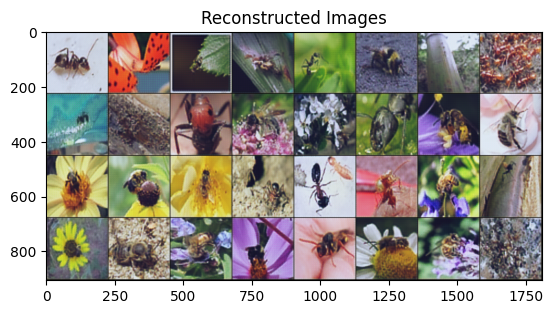

<ipython-input-3-2b3603da00fa>:81: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(original_flat[i], reconstructed_flat[i], multichannel=True)


ZeroDivisionError: division by zero

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

# the Convolutional Autoencoder (CAE) architecture
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # 112x112x16
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 56x56x32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 28x28x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 56x56x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 112x112x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # 224x224x3
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Custom Dataset for Hymenoptera
class HymenopteraDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data = datasets.ImageFolder(root=data_path, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# visualize images
def imshow(img, title):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def compute_metrics(original, reconstructed):
    mse_values = []
    rmse_values = []
    ssim_values = []
    psnr_values = []

    original_flat = original.reshape(original.shape[0], -1)
    reconstructed_flat = reconstructed.reshape(reconstructed.shape[0], -1)

    for i in range(original_flat.shape[0]):
        mse = mean_squared_error(original_flat[i], reconstructed_flat[i])
        rmse = np.sqrt(mse)
        ssim_value = ssim(original_flat[i], reconstructed_flat[i], multichannel=True)
        psnr_value = psnr(original_flat[i], reconstructed_flat[i])

        ssim_value = max(ssim_value, 1e-10)

        mse_values.append(mse)
        rmse_values.append(rmse)
        ssim_values.append(ssim_value)
        psnr_values.append(psnr_value)

    return np.mean(mse_values), np.mean(rmse_values), np.mean(ssim_values), np.mean(psnr_values)

# train autoencoder
def train_autoencoder(model, criterion, optimizer, train_loader, num_epochs=10):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# generate t-SNE and PCA plots
def visualize_features(features, labels, title):
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(features)

    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(features)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", 2))
    plt.title('t-SNE Plot')
    plt.colorbar(ticks=range(2), label='Classes')

    plt.subplot(1, 2, 2)
    plt.scatter(pca_results[:, 0], pca_results[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", 2))
    plt.title('PCA Plot')
    plt.colorbar(ticks=range(2), label='Classes')

    plt.suptitle(title)
    plt.show()

# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 20

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
data_path = "hymenoptera_data"
hymenoptera_dataset = HymenopteraDataset(data_path, transform=transform)

# Split dataset
train_set, _ = train_test_split(hymenoptera_dataset, test_size=0.2, random_state=42)

# Dataloader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Initialize model
model = CAE()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train autoencoder
train_autoencoder(model, criterion, optimizer, train_loader, num_epochs=num_epochs)

# Visualize reconstructed images
dataiter = iter(train_loader)
images, _ = next(dataiter)
reconstructed = model(images)
imshow(torchvision.utils.make_grid(images), "Original Images")
imshow(torchvision.utils.make_grid(reconstructed.detach()), "Reconstructed Images")

# Compute metrics
original_images = images.permute(0, 2, 3, 1).numpy()
reconstructed_images = reconstructed.detach().permute(0, 2, 3, 1).numpy()
mse, rmse, ssim_value, psnr_value = compute_metrics(original_images, reconstructed_images)
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, SSIM: {ssim_value:.4f}, PSNR: {psnr_value:.4f}")

# t-SNE and PCA plots
with torch.no_grad():
    encoded_features = []
    labels = []
    for images, labels_batch in train_loader:
        features = model.encoder(images)
        encoded_features.extend(features.view(features.size(0), -1).numpy())
        labels.extend(labels_batch.numpy())

visualize_features(encoded_features, labels, "Feature Representations")

# MLP Classifier using encoded features
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize classifier
input_size = encoded_features[0].shape[0]
hidden_size = 64
num_classes = 2
classifier = MLPClassifier(input_size, hidden_size, num_classes)

# Loss function and optimizer for classifier
criterion_classifier = nn.CrossEntropyLoss()
optimizer_classifier = optim.Adam(classifier.parameters(), lr=learning_rate)

# Train classifier
writer = SummaryWriter()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for features, labels_batch in train_loader:
        optimizer_classifier.zero_grad()
        outputs = classifier(model.encoder(features))
        loss = criterion_classifier(outputs, labels_batch)
        loss.backward()
        optimizer_classifier.step()

        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/train', accuracy, epoch)

writer.close()
